In [1]:
import numpy as np
import torch
from torch import nn
%matplotlib notebook

import qucumber
from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import MetricEvaluator, LivePlotting
from qucumber.utils.data import load_data
from qucumber.utils import training_statistics as ts

from masked_rbm import MaskedBinaryRBM

qucumber.set_random_seed(161)

In [2]:
data, psi = load_data("../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt", 
                      "../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_psi.txt")

In [3]:
nn_state = PositiveWaveFunction(10, 10, gpu=False)
space = nn_state.generate_hilbert_space()
init_params = {k: v.clone() for k, v in nn_state.rbm_am.named_parameters()}  # save the initial weights for later

In [4]:
me = MetricEvaluator(50, {"fidelity": ts.fidelity}, 
                     target_psi=psi, verbose=True, space=space)
lp = LivePlotting(50, me, "fidelity")
cbs = [me, lp]

We begin by training the unmasked model for 500 epochs to create a mask.

<IPython.core.display.Javascript object>


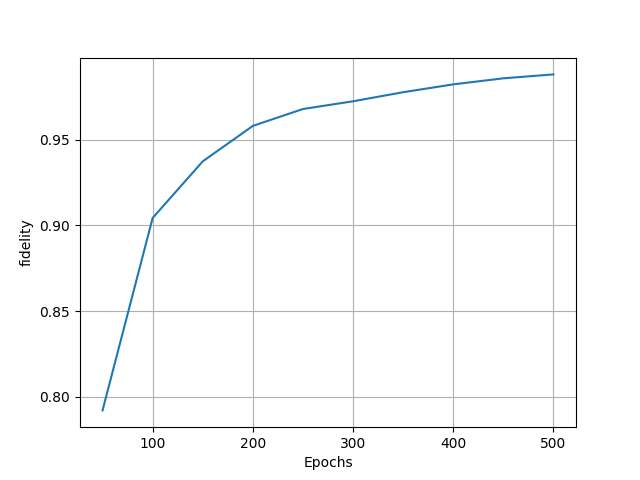

Epoch: 50	fidelity = 0.792118
Epoch: 100	fidelity = 0.904313
Epoch: 150	fidelity = 0.937336
Epoch: 200	fidelity = 0.958010
Epoch: 250	fidelity = 0.967849
Epoch: 300	fidelity = 0.972355
Epoch: 350	fidelity = 0.977644
Epoch: 400	fidelity = 0.982219
Epoch: 450	fidelity = 0.985747
Epoch: 500	fidelity = 0.988031



In [5]:
me.clear_history()  # clear the callback's internal history
nn_state.fit(data, lr=0.01, epochs=500, progbar="notebook", callbacks=cbs)

In [6]:
# mask 50% of the weights which have smallest magnitudes
#  I won't mask the biases as I found that tends to degrade performance
masks = {k: MaskedBinaryRBM.create_mask(v, p=(0.5 if "bias" not in k else 0)) 
         for k, v in nn_state.rbm_am.named_parameters()}
rbm = MaskedBinaryRBM(init_params, masks, gpu=False)

In [7]:
nn_state2 = PositiveWaveFunction(10, 10, gpu=False, module=rbm)

<IPython.core.display.Javascript object>


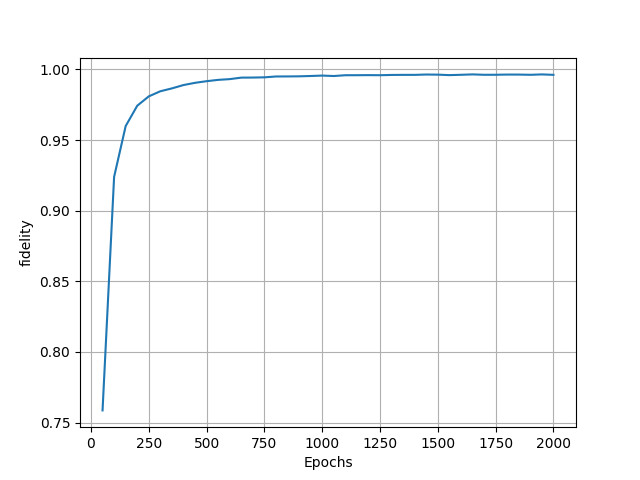

Epoch: 50	fidelity = 0.758657
Epoch: 100	fidelity = 0.923910
Epoch: 150	fidelity = 0.959870
Epoch: 200	fidelity = 0.974274
Epoch: 250	fidelity = 0.980897
Epoch: 300	fidelity = 0.984509
Epoch: 350	fidelity = 0.986536
Epoch: 400	fidelity = 0.988904
Epoch: 450	fidelity = 0.990477
Epoch: 500	fidelity = 0.991632
Epoch: 550	fidelity = 0.992568
Epoch: 600	fidelity = 0.993091
Epoch: 650	fidelity = 0.994154
Epoch: 700	fidelity = 0.994202
Epoch: 750	fidelity = 0.994361
Epoch: 800	fidelity = 0.994962
Epoch: 850	fidelity = 0.994999
Epoch: 900	fidelity = 0.995076
Epoch: 950	fidelity = 0.995310
Epoch: 1000	fidelity = 0.995597
Epoch: 1050	fidelity = 0.995286
Epoch: 1100	fidelity = 0.995849
Epoch: 1150	fidelity = 0.995869
Epoch: 1200	fidelity = 0.995928
Epoch: 1250	fidelity = 0.995862
Epoch: 1300	fidelity = 0.996052
Epoch: 1350	fidelity = 0.996111
Epoch: 1400	fidelity = 0.996104
Epoch: 1450	fidelity = 0.996351
Epoch: 1500	fidelity = 0.996255
Epoch: 1550	fidelity = 0.995925
Epoch: 1600	fidelity = 0.996

In [8]:
me.clear_history()
nn_state2.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

Note that at the 500th epoch, the fidelity is already higher than that of the original (unmasked) model at the same epoch. We let the model train further just to make sure the fidelity doesn't plateau, and to see how well the training converges. I found that fidelity does start plateau-ing earlier than 99% fidelity when more than 70% of the weights are being pruned. 65% pruning gave a plateau around 99.2% fidelity, 70% pruning gave a plateau around 97.5% fidelity, 80% pruning plateau'd around 86% fidelity, 90% pruning plateau'd around 57% fidelity.

Next, we check the fidelity of the masked model when its weights are set to their initial values. We don't worry about the biases as they are, by default, set to 0 upon initialization of the model.

In [9]:
nn_s = PositiveWaveFunction(10,10,gpu=False)
nn_s.rbm_am.weights = nn.Parameter(init_params["weights"].clone() * masks["weights"])

In [10]:
ts.fidelity(nn_s, psi, space)

0.4314279355873957

Compare to the fidelity of a model with identical initial parameters, but with no masking applied:

In [11]:
nn_s_unmasked = PositiveWaveFunction(10,10,gpu=False)
nn_s_unmasked.rbm_am.weights = nn.Parameter(init_params["weights"].clone())
ts.fidelity(nn_s_unmasked, psi, space)

0.4262501000717602

We see that masking improves the initial model. Lastly, we will train this model for 2000 epochs (without enforcing weight masking) in order to compare the performance of the masked model.

<IPython.core.display.Javascript object>


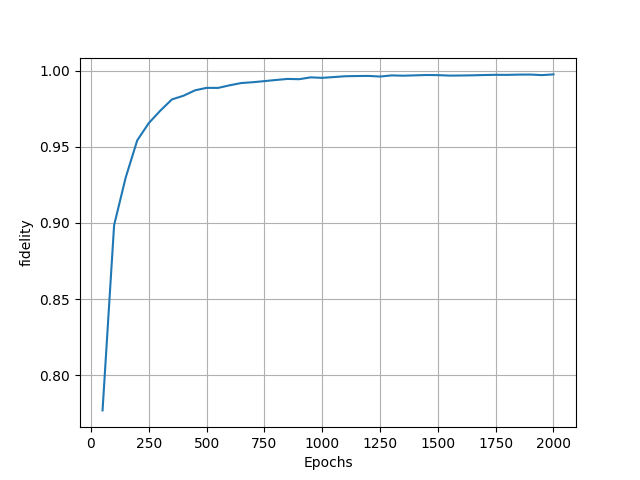

Epoch: 50	fidelity = 0.776727
Epoch: 100	fidelity = 0.898586
Epoch: 150	fidelity = 0.929849
Epoch: 200	fidelity = 0.954337
Epoch: 250	fidelity = 0.965711
Epoch: 300	fidelity = 0.973910
Epoch: 350	fidelity = 0.981283
Epoch: 400	fidelity = 0.983690
Epoch: 450	fidelity = 0.987269
Epoch: 500	fidelity = 0.988877
Epoch: 550	fidelity = 0.988850
Epoch: 600	fidelity = 0.990574
Epoch: 650	fidelity = 0.992054
Epoch: 700	fidelity = 0.992592
Epoch: 750	fidelity = 0.993312
Epoch: 800	fidelity = 0.994069
Epoch: 850	fidelity = 0.994757
Epoch: 900	fidelity = 0.994573
Epoch: 950	fidelity = 0.995781
Epoch: 1000	fidelity = 0.995464
Epoch: 1050	fidelity = 0.995990
Epoch: 1100	fidelity = 0.996523
Epoch: 1150	fidelity = 0.996659
Epoch: 1200	fidelity = 0.996735
Epoch: 1250	fidelity = 0.996337
Epoch: 1300	fidelity = 0.997073
Epoch: 1350	fidelity = 0.996883
Epoch: 1400	fidelity = 0.997101
Epoch: 1450	fidelity = 0.997335
Epoch: 1500	fidelity = 0.997256
Epoch: 1550	fidelity = 0.996939
Epoch: 1600	fidelity = 0.997

In [12]:
me.clear_history()
nn_s.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

At epoch 2000, the unmasked model seems to have won out slightly, but the fidelities are too close together to make any solid conclusion. If we consider that the mask required 500 training epochs to produce, it makes more sense to compare the 1500th epoch of the masked model to the 2000th epoch of the unmasked. These two values are still relatively close together. Due to the closeness of the fidelities, it doesn't really make much sense to draw conclusions on each model's relative performance from these figures. Indeed, with the right random seed, the masked model sometimes wins out. 

We *can*, however, conclude that even with only half the number of weights, the RBM is still able to reconstruct the desired wavefunction with about the same accuracy.